## Dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inflection
import warnings
warnings.filterwarnings('ignore')

!cp ../script/common_function.py ../notebook
pd.set_option('max_columns', 50)

## Load the dataset

In [2]:
df = pd.read_csv('../dataset/marketing_campaign_data.csv')
df.sample()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1581,1581,9952,1947,S2,Bertunangan,78093000.0,0,0,11-12-2013,53,368000,32000,639000,13000,43000,10000,1,4,7,5,1,0,0,0,0,0,0,3,11,0


## Lowercase column names

In [3]:
df = df.drop(["Unnamed: 0"], axis=1)
df.columns = [inflection.underscore(col) for col in df.columns]
df.sample()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
365,10704,1969,S1,Lajang,54803000.0,0,1,21-08-2012,65,404000,0,92000,28000,27000,142000,2,6,2,9,4,0,0,0,0,0,0,3,11,0


## Pre-exploration

In [4]:
df.shape

(2240, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2240 non-null   int64  
 1   year_birth             2240 non-null   int64  
 2   education              2240 non-null   object 
 3   marital_status         2240 non-null   object 
 4   income                 2216 non-null   float64
 5   kidhome                2240 non-null   int64  
 6   teenhome               2240 non-null   int64  
 7   dt_customer            2240 non-null   object 
 8   recency                2240 non-null   int64  
 9   mnt_coke               2240 non-null   int64  
 10  mnt_fruits             2240 non-null   int64  
 11  mnt_meat_products      2240 non-null   int64  
 12  mnt_fish_products      2240 non-null   int64  
 13  mnt_sweet_products     2240 non-null   int64  
 14  mnt_gold_prods         2240 non-null   int64  
 15  num_

In [6]:
from common_function import dataset_summary
summary = dataset_summary(df)
summary.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
variable,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
no_unique,2240,59,5,6,1974,3,3,663,100,776,158,558,182,177,213,15,15,14,14,16,2,2,2,2,2,2,1,1,2
pandas_dtype,int64,int64,object,object,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
missing_value,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
%_missing_values,0.0,0.0,0.0,0.0,1.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique_value,"[5524, 2174, 4141, 6182, 5324, 7446, 965, 6177...","[1957, 1954, 1965, 1984, 1981, 1967, 1971, 198...","[S1, S3, S2, SMA, D3]","[Lajang, Bertunangan, Menikah, Cerai, Janda, D...","[58138000.0, 46344000.0, 71613000.0, 26646000....","[0, 1, 2]","[0, 1, 2]","[04-09-2012, 08-03-2014, 21-08-2013, 10-02-201...","[58, 38, 26, 94, 16, 34, 32, 19, 68, 11, 59, 8...","[635000, 11000, 426000, 173000, 520000, 235000...","[88000, 1000, 49000, 4000, 43000, 42000, 65000...","[546000, 6000, 127000, 20000, 118000, 98000, 1...","[172000, 2000, 111000, 10000, 46000, 0, 50000,...","[88000, 1000, 21000, 3000, 27000, 42000, 49000...","[88000, 6000, 42000, 5000, 15000, 14000, 27000...","[3, 2, 1, 5, 4, 15, 7, 0, 6, 9, 12, 8, 10, 13,...","[8, 1, 2, 5, 6, 7, 4, 3, 11, 0, 27, 10, 9, 23,...","[10, 1, 2, 0, 3, 4, 6, 28, 9, 5, 8, 7, 11, 22]","[4, 2, 10, 6, 7, 0, 3, 8, 5, 12, 9, 13, 11, 1]","[7, 5, 4, 6, 8, 9, 20, 2, 3, 1, 10, 0, 14, 19,...","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]",[3],[11],"[1, 0]"


**Observation**
* There are 2240 rows and 29 variables that describe the customer behavior and demographics.
* Only **income** which has 24 rows of missing values.
* **dt_customer** needs to be parsed into datetime type.

From the existing features, we can extract new features as follows:
* From **year_birth**, we can get customer **age** by substracting it with 2022.
* From **marital_status**, we can identify which customer is in **relationship** or not.
* From **kidhome**, and **teenhome**, we know the number of **children** that customer has.
* From new feature, **children**, we can know if the customer is **parent** or not.
* From **dt_customer**, we can get **year_join** of each customer.
* From **mnt_coke**, **mnt_fruits**, **mnt_meat_products**, **mnt_fish_products**, **mnt_sweet_products**, and **mnt_gold_prods**, we sum them all to get **total_amount_spent**.
* From **num_deals_purchases**, **num_web_purchases**, **num_catalog_purchases**, and **num_store_purchases**, we add them all to get **total_purchase_count**.
* From **accepted_cmp3**, **accepted_cmp4**, **accepted_cmp5**, **accepted_cmp1**, and **accepted_cmp2**, add them all to get **total_accepted_campaign**.
* To create **conversion_rate**, we divide **total_purchase_count** by **num_web_visits_month**


## Feature Engineering

In [7]:
def feature_engineering(df):
    df = df.copy()
    
    # age
    df['age'] = 2022 - df['year_birth']

    def age_range(row):
        if (row >= 0) & (row < 10):
            return 'Child'
        if (row >= 10) & (row < 26):
            return 'Gen Z'
        if (row >= 26) & (row < 42):
            return 'Millennials'
        if (row >= 42) & (row < 58):
            return 'Gen X'
        if (row >= 58):
            return 'Boomers'    

    # classified age range 
    # source: https://www.beresfordresearch.com/age-range-by-generation/
    df['age_range'] = df['age'].apply(age_range)
    
    def relationship_status(row):
        if row in ['Bertunangan', 'Menikah']:
            return True
        if row in ['Lajang','Cerai', 'Janda', 'Duda']:
            return False
    
    # in_relationship (True or False)
    df['in_relationship'] = df['marital_status'].apply(relationship_status)
    
    # children
    df['children'] = df[['kidhome', 'teenhome']].sum(axis=1)
    
    # parent
    df['is_parent'] = np.where(df['children'] > 0, 1, 0)
    
    # year join
    df['dt_customer'] = pd.to_datetime(df['dt_customer'])
    df['year_join'] = 2022 - df['dt_customer'].dt.year
    
    # total amount spent
    amount_spent = [
        'mnt_coke', 'mnt_fruits','mnt_meat_products', 
        'mnt_fish_products', 'mnt_sweet_products','mnt_gold_prods'
    ]
    df['total_amount_spent'] = df[amount_spent].sum(axis=1)
    
    # total purchase count
    purchase_count = [
        'num_deals_purchases', 'num_web_purchases',
        'num_catalog_purchases', 'num_store_purchases'
    ]
    df['total_purchase_count'] = df[purchase_count].sum(axis=1)
    
    # total accepted campaign
    accepted_campaign = [
        'accepted_cmp3', 'accepted_cmp4', 
        'accepted_cmp5', 'accepted_cmp1',
        'accepted_cmp2'
    ]
    df['total_accepted_campaign'] = df[accepted_campaign].sum(axis=1)
    
    # conversion rate
    df['conversion_rate'] = 100 * df['total_purchase_count'] / df['num_web_visits_month']
    df['conversion_rate'] = df['conversion_rate'].replace([np.inf, -np.inf], 0)
    
    # drop missing values
    return df.dropna()

df = feature_engineering(df)
df.sample(5)

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,age,age_range,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate
1153,5031,1974,S1,Bertunangan,83145000.0,0,0,2012-09-22,14,777000,35000,731000,39000,137000,114000,1,5,9,11,2,0,0,1,0,0,0,3,11,1,48,Gen X,True,0,0,10,1833000,26,1,1300.000000
2192,7990,1947,S1,Menikah,27469000.0,0,0,2012-02-08,2,9000,1000,2000,3000,2000,0,1,0,0,3,6,0,0,0,0,0,0,3,11,0,75,Boomers,True,0,0,10,17000,4,0,66.666667
1674,3389,1970,S1,Menikah,69016000.0,0,1,2012-11-22,61,726000,53000,363000,123000,107000,161000,4,8,9,13,5,0,0,0,0,0,0,3,11,0,52,Gen X,True,1,1,10,1533000,34,0,680.000000
1848,4609,1966,S3,Menikah,57705000.0,0,1,2014-11-01,14,383000,0,53000,6000,4000,40000,3,8,1,6,6,0,0,0,0,0,0,3,11,0,56,Gen X,True,1,1,8,486000,18,0,300.000000
1180,359,1950,S1,Bertunangan,48070000.0,0,1,2013-01-13,33,373000,14000,83000,6000,9000,19000,3,8,2,6,7,0,0,0,0,0,1,3,11,0,72,Boomers,True,1,1,9,504000,19,0,271.428571


## Exploratory Data Analysis

In [8]:
def scatter_and_hist_plot(df, x, y):
    sns.set_theme(style="whitegrid")
    sns.jointplot(data=df, y=y, x=x, kind='reg')
    plt.show()

### Income vs Total Amount Spent

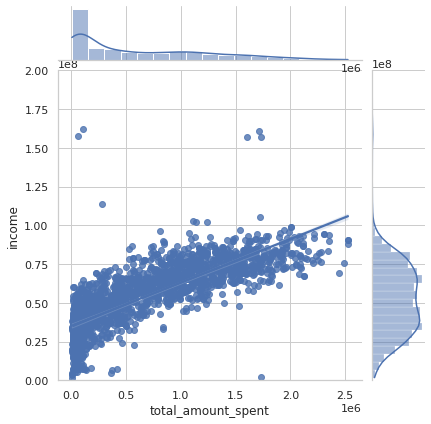

In [9]:
sns.set_theme(style="whitegrid")
sns.jointplot(data=df, x='total_amount_spent', y='income', kind='reg')
plt.ylim([0, 2e8])
plt.show()

### Income vs Conversion Rate

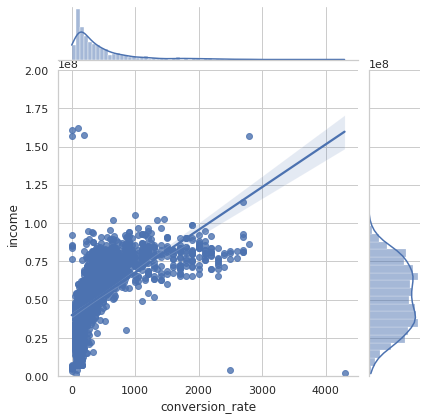

In [10]:
sns.set_theme(style="whitegrid")
sns.jointplot(data=df, x='conversion_rate', y='income', kind='reg')
plt.ylim([0, 2e8])
plt.show()

### Age vs Conversion Rate

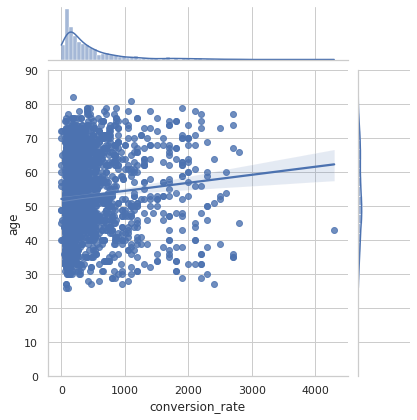

In [11]:
sns.set_theme(style="whitegrid")
sns.jointplot(data=df,x='conversion_rate', y='age', kind='reg')
plt.ylim([0, 90])
plt.xlim([0, 3000])
plt.show()

### Age vs Income

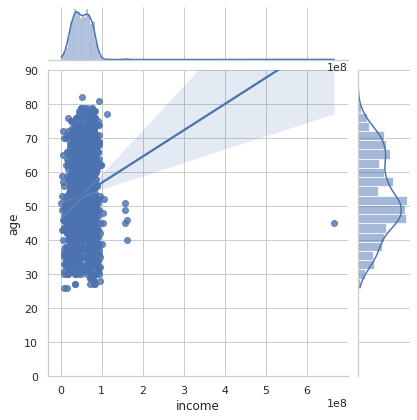

In [12]:
sns.set_theme(style="whitegrid")
sns.jointplot(data=df,x='income', y='age', kind='reg')
plt.ylim([0, 90])
plt.show()

### Correlation analysis

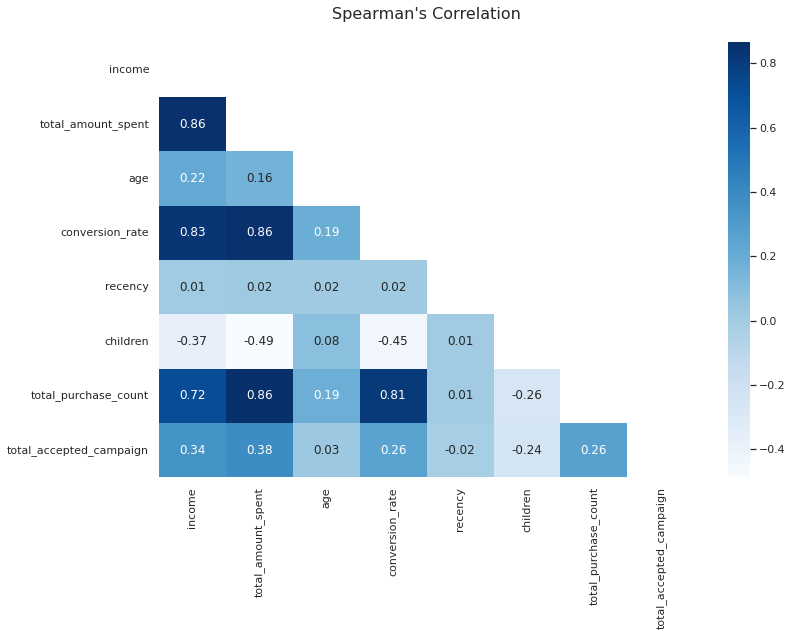

In [13]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
col_to_plot = [
    'income', 'total_amount_spent', 'age', 'conversion_rate',
    'recency', 'children', 'total_purchase_count', 'total_accepted_campaign'
]
corr_df = df[col_to_plot].corr(method='spearman')
sns.heatmap(
    corr_df, 
    ax=ax,
    mask=np.triu(np.ones_like(corr_df)),
    cmap='Blues', 
    annot=True, 
    fmt='.2f'
)
ax.set_title("Spearman's Correlation\n", fontsize=16)
plt.show()

## Data Preprocessing

### Handle missing values

In [14]:
df = df.dropna()
df.isnull().sum().sum()

0

### Handle duplicate data

In [15]:
df.duplicated().sum()

0

### Feature encoding

#### Education

In [16]:
df['education'] = df['education'].map({
    'S1': 2, 
    'S3': 4, 
    'S2': 3, 
    'SMA': 0, 
    'D3': 1
})

df['education'].unique()

array([2, 4, 3, 0, 1])

In [17]:
df['in_relationship'] = df['in_relationship'].astype(int)
df['in_relationship'].unique()

array([0, 1])

#### marital_status and age_range

In [18]:
from feature_engine.encoding import OneHotEncoder

one_hot = OneHotEncoder(
    variables=['marital_status', 'age_range'],
    drop_last_binary=True
)

df = one_hot.fit_transform(df)
df.sample(5)

,id,year_birth,education,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,age,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X,age_range_Millennials
1735,10092,1954,2,70044000.0,0,1,2013-02-18,46,1073000,0,250000,153000,14000,14000,4,7,10,5,5,0,0,0,0,0,0,3,11,0,68,0,1,1,9,1504000,26,0,520.000000,0,0,0,1,0,0,1,0,0
1969,4331,1978,3,85738000.0,0,0,2014-01-23,41,913000,26000,376000,17000,26000,13000,1,3,6,11,1,0,1,1,0,0,0,3,11,0,44,1,0,0,8,1371000,21,2,2100.000000,0,1,0,0,0,0,0,1,0
40,8601,1980,2,80011000.0,0,1,2013-04-29,3,421000,76000,536000,82000,178000,102000,2,8,6,5,4,0,0,0,0,0,0,3,11,0,42,1,1,1,9,1395000,21,0,525.000000,0,0,1,0,0,0,0,1,0
491,22,1976,2,46310000.0,1,0,2012-03-12,99,185000,2000,88000,15000,5000,14000,2,6,1,5,8,0,0,0,0,0,0,3,11,0,46,0,1,1,10,309000,14,0,175.000000,0,0,0,1,0,0,0,1,0
1732,4351,1955,2,37244000.0,1,1,2013-04-27,90,18000,2000,10000,0,0,25000,1,1,1,2,7,1,0,0,0,0,0,3,11,0,67,0,2,1,9,55000,5,1,71.428571,0,0,0,1,0,0,1,0,0


In [19]:
df.iloc[:, -10:-1].sample(3)

,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X
625,116.666667,0,0,1,0,0,0,0,1
2144,466.666667,1,0,0,0,0,0,0,1
1266,362.500000,0,0,1,0,0,0,1,0


### Feature selection

In [20]:
df_clustering = df.copy()
df_clustering = df.drop(
    columns=[
        'id', 'accepted_cmp3', 'accepted_cmp4', 
        'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2',
        'z_cost_contact', 'z_revenue', 'dt_customer'
    ]
)
df_clustering.sample(3)

,year_birth,education,income,kidhome,teenhome,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,complain,response,age,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X,age_range_Millennials
1893,1968,2,61671000.0,0,1,23,641000,7000,56000,0,0,28000,8,10,4,6,8,0,0,54,0,1,1,8,732000,28,2,350.000000,0,0,0,1,0,0,0,1,0
228,1972,4,79930000.0,0,0,72,792000,86000,740000,67000,51000,17000,1,3,5,8,2,0,0,50,1,0,0,10,1753000,17,0,850.000000,0,0,1,0,0,0,0,1,0
1909,1980,3,31535000.0,1,0,95,15000,4000,13000,0,0,19000,1,1,1,2,7,0,0,42,1,1,1,9,51000,5,1,71.428571,0,0,1,0,0,0,0,1,0


In [21]:
numerical = [
    'year_birth', 'education', 'income', 'kidhome', 'teenhome', 'recency',
    'mnt_coke', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products',
    'mnt_sweet_products', 'mnt_gold_prods', 'num_deals_purchases',
    'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases',
    'num_web_visits_month', 'age', 'children', 'year_join',
    'total_amount_spent', 'total_purchase_count', 'total_accepted_campaign',
    'conversion_rate'
]

### Feature standarization

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for col in numerical:
    df_clustering[col] = scaler.fit_transform(df_clustering[[col]])

df_clustering.sample(5)

,year_birth,education,income,kidhome,teenhome,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,complain,response,age,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X,age_range_Millennials
693,-1.404538,-2.448403,-1.563624,-0.823663,-0.929754,-0.690537,-0.899447,-0.662861,-0.714047,-0.633216,-0.488203,-0.656310,-0.689411,-1.127852,-0.913593,-0.864298,0.279329,0,0,1.404538,1,-1.266290,0,0.040854,-0.959936,-1.291747,-0.439502,-0.728578,0,1,0,0,0,0,1,0,0
592,-0.319409,0.538244,0.709491,-0.823663,-0.929754,1.555738,-0.039628,2.528447,2.086041,1.722803,2.433363,2.335332,-0.689411,-0.397609,1.478512,0.983655,-1.786251,0,0,0.319409,0,-1.266290,0,0.040854,1.443979,0.666571,-0.439502,3.192479,1,0,0,0,0,0,0,1,0
1547,-0.486352,-0.457305,-0.847287,-0.823663,-0.929754,0.035182,-0.754167,-0.562347,-0.522321,-0.468843,-0.634282,0.096426,-0.689411,-0.032488,-0.913593,-0.864298,1.105561,0,1,0.486352,0,-1.266290,0,1.499725,-0.730992,-0.900084,-0.439502,-0.694481,1,0,0,0,0,0,1,0,0
1205,-1.070652,0.538244,-0.047587,-0.823663,0.908171,1.313832,0.707524,-0.336192,-0.366265,-0.541898,-0.512550,-0.289592,0.350695,2.158239,0.453324,-0.248313,1.105561,0,0,1.070652,1,0.069377,1,0.040854,0.128379,0.927681,1.032596,-0.336472,0,0,1,0,0,0,1,0,0
1675,1.850851,-1.452854,-1.279115,-0.823663,-0.929754,-1.070676,-0.881657,-0.461834,-0.647165,-0.249678,-0.390818,-0.675611,-0.689411,-1.127852,-0.571864,-0.556305,-0.546903,0,0,-1.850851,1,-1.266290,0,1.499725,-0.872008,-1.030638,-0.439502,-0.541049,0,1,0,0,0,0,0,0,1


In [23]:
df_clustering.sample().T

,335
year_birth,-0.736766
education,-0.457305
income,0.402210
kidhome,-0.823663
teenhome,2.746095
recency,-0.379515
mnt_coke,0.034494
mnt_fruits,0.493046
mnt_meat_products,0.356051
mnt_fish_products,2.069814


## Modelling

### Elbow method

In [24]:
from sklearn.cluster import KMeans

col_to_plot = [
    'income', 'total_amount_spent', 'age', 'conversion_rate',
    'recency', 'children', 'total_purchase_count', 'total_accepted_campaign'
]
X = df_clustering.copy()
inertia = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X.values)
    inertia.append(kmeans.inertia_)

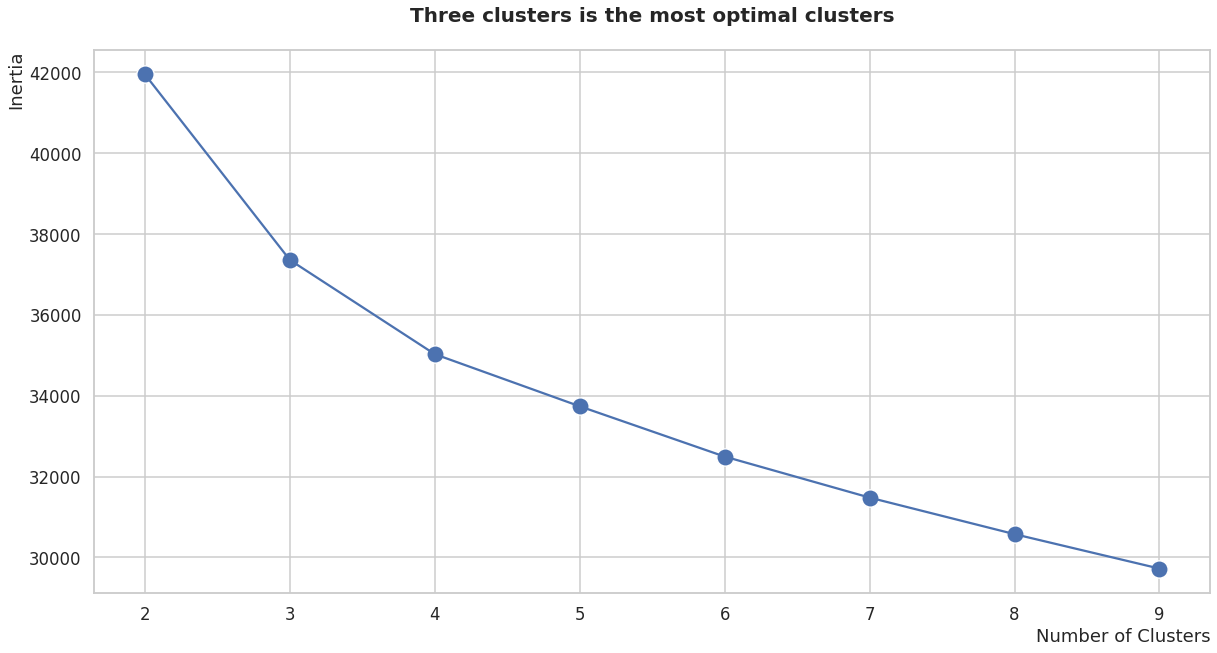

In [25]:
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(x=range(2, 10), y=inertia, markers=True, ax=ax)
sns.scatterplot(x=range(2, 10), y=inertia, s=300, ax=ax)
plt.title("Three clusters is the most optimal clusters\n", fontsize=20, fontweight='bold')
plt.ylabel('Inertia', loc='top')
plt.xlabel('Number of Clusters', loc='right')
#plt.ylim([0, 600])
plt.show()

### Silhoutte score

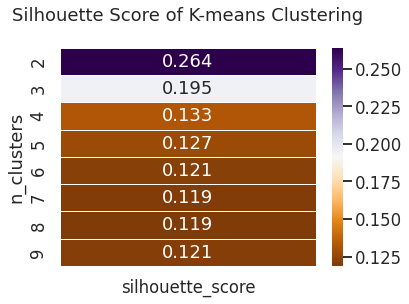

In [26]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2, 10)
    results = []

    for i in clusters_range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='PuOr')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering\n')
    plt.show()
    
visualize_silhouette_layer(X)

### K-means modelling with optimal clusters

In [27]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X.values)

X['cluster'] = kmeans.labels_
df_clustering['cluster'] = kmeans.labels_
df['cluster'] = kmeans.labels_
X.sample(5)

,year_birth,education,income,kidhome,teenhome,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,complain,response,age,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X,age_range_Millennials,cluster
2036,0.682249,-0.457305,0.927526,1.039044,0.908171,1.555738,0.740138,1.397668,0.400638,1.010518,0.826501,0.328037,0.870748,2.158239,0.111595,1.907631,0.279329,0,0,-0.682249,1,1.405045,1,1.499725,0.831802,1.841563,-0.439502,0.089730,0,0,1,0,0,0,0,1,0,2
1910,-0.736766,-1.452854,1.616928,-0.823663,-0.929754,-0.586863,0.556315,3.935637,0.824218,2.672516,-0.098661,-0.308893,-1.209464,-0.397609,0.795053,2.215623,-2.199366,0,0,0.736766,1,-1.266290,0,-1.418018,1.087291,0.797126,-0.439502,-0.899058,0,1,0,0,0,0,1,0,0,0
754,0.849192,-0.457305,0.934610,-0.823663,-0.929754,0.242531,1.196731,1.674081,0.922310,1.211419,1.289083,0.694755,-0.689411,1.427997,1.136783,0.059679,-0.960019,0,0,-0.849192,1,-1.266290,0,-1.418018,1.380937,0.797126,-0.439502,0.532980,0,1,0,0,0,0,0,1,0,0
583,-1.488010,0.538244,-0.988682,-0.823663,-0.929754,0.277089,-0.795675,-0.361320,-0.642707,-0.541898,-0.390818,0.154329,-0.689411,-0.762731,-0.571864,-0.864298,0.692445,0,0,1.488010,1,-1.266290,0,0.040854,-0.770808,-1.030638,-0.439502,-0.694481,0,0,1,0,0,0,1,0,0,1
235,0.515306,-1.452854,-1.198312,1.039044,-0.929754,0.000624,-0.890552,-0.436705,-0.656083,-0.578425,-0.463857,-0.444000,-0.169358,-0.762731,-0.913593,-0.556305,0.279329,0,0,-0.515306,1,0.069377,1,0.040854,-0.893575,-0.900084,-0.439502,-0.626289,0,0,1,0,0,0,0,1,0,1


### Dimensionality Reduction

In [28]:
from sklearn.decomposition import PCA

df_red = df_clustering.copy()

dim_reduction = PCA(n_components=2, random_state=42)
df_red[['pc1', 'pc2']] = dim_reduction.fit_transform(df_red.drop('cluster', axis=1))

In [29]:
col_to_show = ['pc1', 'pc2', 'cluster']
df_red[col_to_show].sample(5)

,pc1,pc2,cluster
488,-3.452673,-1.296266,1
1531,-1.689584,2.435169,2
1132,-2.919451,-1.953852,1
389,0.854918,1.770998,2
1974,-1.856335,0.331699,1


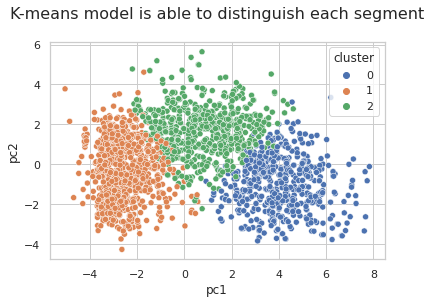

In [30]:
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df_red, x='pc1', y='pc2', hue='cluster', palette="deep")
plt.title("K-means model is able to distinguish each segment\n", fontsize=16)
plt.show()

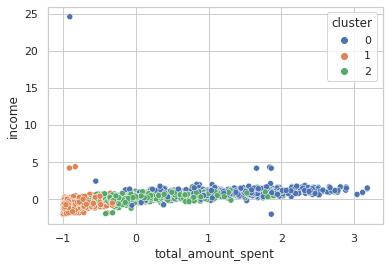

In [31]:
sns.scatterplot(data=X, x='total_amount_spent', y='income', hue='cluster', palette="deep")
plt.show()

### Descriptive Statistics of each Cluster

In [32]:
features = ['income', 'total_amount_spent', 'cluster']
df[features].groupby('cluster')['income', 'total_amount_spent'].agg(['count', 'mean', 'median'])

income                           total_amount_spent                \
         count          mean      median              count          mean   
cluster                                                                     
0          551  7.749718e+07  76653000.0                551  1.387857e+06   
1         1031  3.483479e+07  34578000.0               1031  9.956353e+04   
2          632  5.831241e+07  58589500.0                632  7.561804e+05   

                    
            median  
cluster             
0        1366000.0  
1          64000.0  
2         685000.0

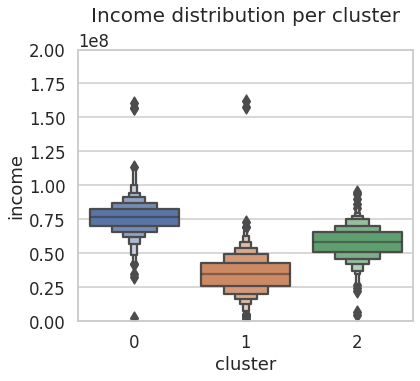

In [33]:
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxenplot(data=df, x='cluster', y='income')
plt.title('Income distribution per cluster\n', fontsize=20)
plt.ylim([0, 2e8])
plt.show()

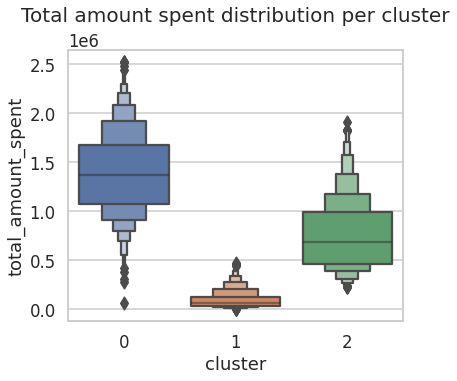

In [34]:
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.boxenplot(data=df, x='cluster', y='total_amount_spent')
plt.title('Total amount spent distribution per cluster\n', fontsize=20)
plt.show()

In [35]:
mapped_cluster = {
    2: "Low Spender",
    1: "Mid Spender",
    0: "High Spender"
}

df['customer_segment'] = df['cluster'].map(mapped_cluster)
df[['customer_segment']].sample(3)

,customer_segment
97,Mid Spender
266,High Spender
1019,Mid Spender


In [36]:
df['customer_segment'].value_counts()[0]

1031

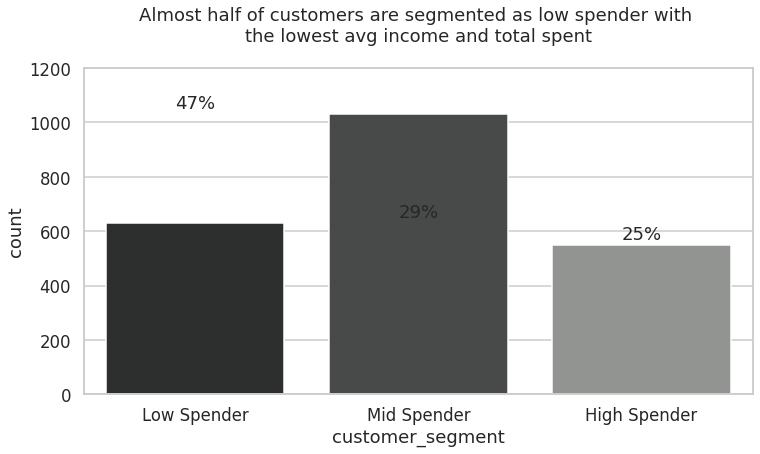

In [37]:
sns.set_theme(context="talk", style="whitegrid")
color_palette = ['#2C302E', '#474A48', '#909590', '#9AE19D', '#537A5A', '#636363']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.countplot(
    x=df['customer_segment'],
    order=["Low Spender", "Mid Spender", "High Spender"], 
    palette=color_palette
)

for i in range(0, 3):
    abs_y = df['customer_segment'].value_counts()[i]
    frac_y = round(100 * abs_y / df.shape[0], 0)
    plt.text(x=i-0.09, y=abs_y+20, s=f'{frac_y:.0f}%')

plt.title('Almost half of customers are segmented as low spender with \nthe lowest avg income and total spent\n')
plt.ylim([0, 1200])
plt.show()

### Customer profile

In [38]:
def age_range(row):
    if (row >= 0) & (row < 10):
        return 'Child'
    if (row >= 10) & (row < 26):
        return 'Gen Z'
    if (row >= 26) & (row < 42):
        return 'Millennials'
    if (row >= 42) & (row < 58):
        return 'Gen X'
    if (row >= 58):
        return 'Boomers'    

df['age_range'] = df['age'].apply(age_range)

In [39]:
df_dummy = pd.read_csv('../dataset/marketing_campaign_data.csv')
df['marital_status'] = df_dummy['Marital_Status'].copy()

In [40]:
df

,id,year_birth,education,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,age,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate,marital_status_Lajang,marital_status_Bertunangan,marital_status_Menikah,marital_status_Cerai,marital_status_Janda,marital_status_Duda,age_range_Boomers,age_range_Gen X,age_range_Millennials,cluster,customer_segment,age_range,marital_status
0,5524,1957,2,58138000.0,0,0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1,65,0,0,0,10,1617000,25,0,357.142857,1,0,0,0,0,0,1,0,0,0,High Spender,Boomers,Lajang
1,2174,1954,2,46344000.0,1,1,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0,68,0,2,1,8,27000,6,0,120.000000,1,0,0,0,0,0,1,0,0,1,Mid Spender,Boomers,Lajang
2,4141,1965,2,71613000.0,0,0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0,57,1,0,0,9,776000,21,0,525.000000,0,1,0,0,0,0,0,1,0,0,High Spender,Gen X,Bertunangan
3,6182,1984,2,26646000.0,1,0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0,38,1,1,1,8,53000,8,0,133.333333,0,1,0,0,0,0,0,0,1,1,Mid Spender,Millennials,Bertunangan
4,5324,1981,4,58293000.0,1,0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0,41,1,1,1,8,422000,19,0,380.000000,0,0,1,0,0,0,0,0,1,1,Mid Spender,Millennials,Menikah
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,61223000.0,0,1,2013-06-13,46,709000,43000,182000,42000,118000,247000,2,9,3,4,5,0,0,0,0,0,0,3,11,0,55,1,1,1,9,1341000,18,0,360.000000,0,0,1,0,0,0,0,1,0,2,Low Spender,Gen X,Menikah
2236,4001,1946,4,64014000.0,2,1,2014-10-06,56,406000,0,30000,0,0,8000,7,8,2,5,7,0,0,0,1,0,0,3,11,0,76,1,3,1,8,444000,22,1,314.285714,0,1,0,0,0,0,1,0,0,2,Low Spender,Boomers,Bertunangan
2237,7270,1981,2,56981000.0,0,0,2014-01-25,91,908000,48000,217000,32000,12000,24000,1,2,3,13,6,0,1,0,0,0,0,3,11,0,41,0,0,0,8,1241000,19,1,316.666667,0,0,0,1,0,0,0,0,1,0,High Spender,Millennials,Cerai
2238,8235,1956,3,69245000.0,0,1,2014-01-24,8,428000,30000,214000,80000,30000,61000,2,6,5,10,3,0,0,0,0,0,0,3,11,0,66,1,1,1,8,843000,23,0,766.666667,0,1,0,0,0,0,1,0,0,2,Low Spender,Boomers,Bertunangan


In [41]:
df.groupby('customer_segment').agg({
    'age_range': 'describe',
    'marital_status': 'describe',
    'children': 'median'
})

age_range                      marital_status         \
                     count unique      top freq          count unique   
customer_segment                                                        
High Spender           551      3  Boomers  215            551      5   
Low Spender            632      3  Boomers  322            632      6   
Mid Spender           1031      3    Gen X  562           1031      6   

                               children  
                      top freq children  
customer_segment                         
High Spender      Menikah  195      0.0  
Low Spender       Menikah  258      1.0  
Mid Spender       Menikah  403      1.0

In [42]:
df.columns

Index(['id', 'year_birth', 'education', 'income', 'kidhome', 'teenhome',
       'dt_customer', 'recency', 'mnt_coke', 'mnt_fruits', 'mnt_meat_products',
       'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods',
       'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases',
       'num_store_purchases', 'num_web_visits_month', 'accepted_cmp3',
       'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2',
       'complain', 'z_cost_contact', 'z_revenue', 'response', 'age',
       'in_relationship', 'children', 'is_parent', 'year_join',
       'total_amount_spent', 'total_purchase_count', 'total_accepted_campaign',
       'conversion_rate', 'marital_status_Lajang',
       'marital_status_Bertunangan', 'marital_status_Menikah',
       'marital_status_Cerai', 'marital_status_Janda', 'marital_status_Duda',
       'age_range_Boomers', 'age_range_Gen X', 'age_range_Millennials',
       'cluster', 'customer_segment', 'age_range', 'marital_status'],
      dtyp

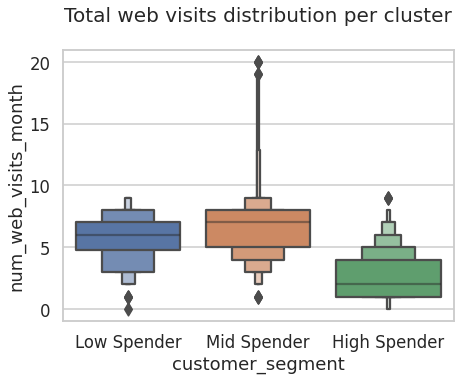

In [43]:
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxenplot(data=df, x='customer_segment', y='num_web_visits_month', order=["Low Spender", "Mid Spender", "High Spender"])
plt.title('Total web visits distribution per cluster\n', fontsize=20)
plt.show()

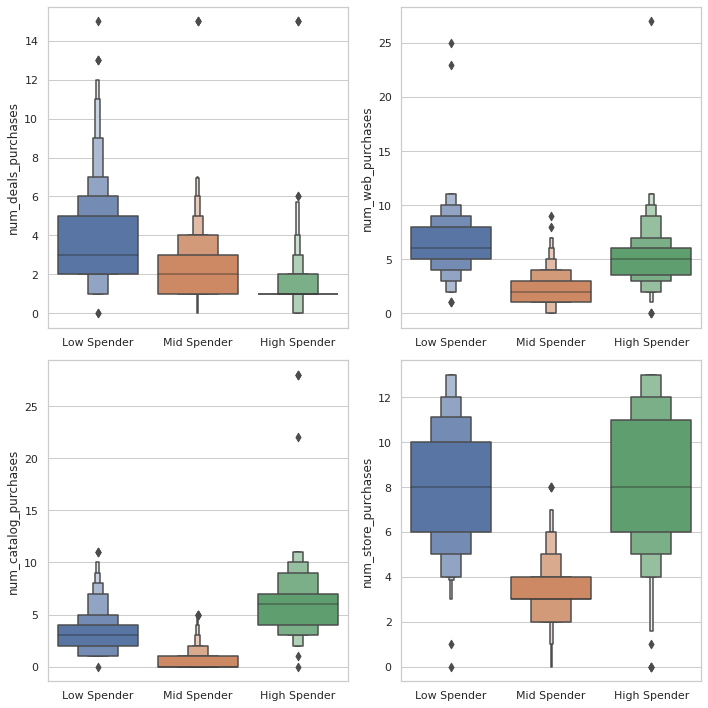

In [44]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
purchase_feats = [
    'num_deals_purchases', 'num_web_purchases', 
    'num_catalog_purchases', 'num_store_purchases'
]
for i, col in enumerate(purchase_feats):
    plt.subplot(2, 2, i+1)
    sns.boxenplot(
        data=df, 
        x='customer_segment', y=col, 
        order=["Low Spender", "Mid Spender", "High Spender"])
    plt.xlabel('')
    plt.tight_layout()

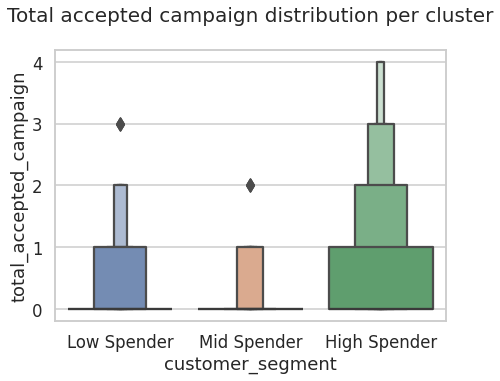

In [45]:
sns.set_theme(context="talk", style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxenplot(data=df, x='customer_segment', y='total_accepted_campaign', order=["Low Spender", "Mid Spender", "High Spender"])
plt.title('Total accepted campaign distribution per cluster\n', fontsize=20)
plt.show()

## Potential Impact

In [59]:
total_spent = df.groupby('customer_segment').agg({'total_amount_spent': 'sum'}).reset_index()
total_spent['id'] = total_spent['customer_segment'].map({
    'High Spender': 2,
    'Mid Spender': 1,
    'Low Spender': 0
})
total_spent = total_spent.sort_values(by='id').reset_index(drop=True)
total_spent

,customer_segment,total_amount_spent,id
0,Low Spender,477906000,0
1,Mid Spender,102650000,1
2,High Spender,764709000,2


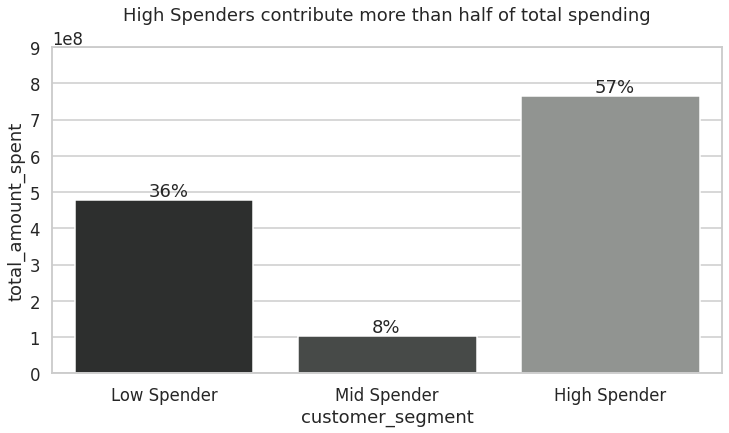

In [71]:
sns.set_theme(context="talk", style="whitegrid")
color_palette = ['#2C302E', '#474A48', '#909590', '#9AE19D', '#537A5A', '#636363']

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(
    x=total_spent['customer_segment'],
    y=total_spent['total_amount_spent'],
    order=["Low Spender", "Mid Spender", "High Spender"], 
    palette=color_palette
)

for i in range(0, 3):
    abs_y = total_spent['total_amount_spent'].iloc[i]
    frac_y = round(100 * abs_y / total_spent['total_amount_spent'].sum(), 0)
    plt.text(x=i-0.07, y=abs_y+1e8 * 0.1, s=f'{frac_y:.0f}%')

plt.title('High Spenders contribute more than half of total spending\n')
plt.ylim([0, 9e8])
plt.show()

In [74]:
# assume 50% reduction for Mid Spender
(
    (df[df['cluster'] == 2]['total_amount_spent'].sum() 
    / df[df['cluster'] == 2]['total_purchase_count'].sum()) 
    * df[df['cluster'] == 2]['num_deals_purchases'].sum()
)

84954688.68703552